In [1]:
import wrangle
import pyspark
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.ion()
plt.rc('figure', figsize=(13,7))
plt.rc('font', size=14)
plt.style.use('ggplot')

In [3]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle.wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


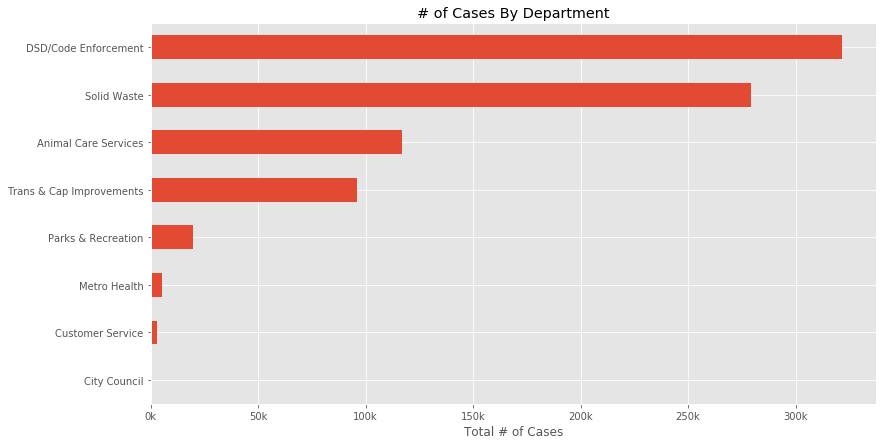

In [4]:
def format_number(x, *args):
    return '{:.0f}k'.format(x / 1000)

(
    df.groupby('department')
    .count()
    .toPandas()
    .set_index('department')
    ['count']
    .sort_values()
    .plot.barh()
)

plt.gca().set(ylabel='', xlabel='Total # of Cases', title='# of Cases By Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number))

[Text(0, 0.5, ''),
 Text(0.5, 0, '% of Cases Closed After Due Date'),
 Text(0.5, 1.0, '% of Late Cases By Department')]

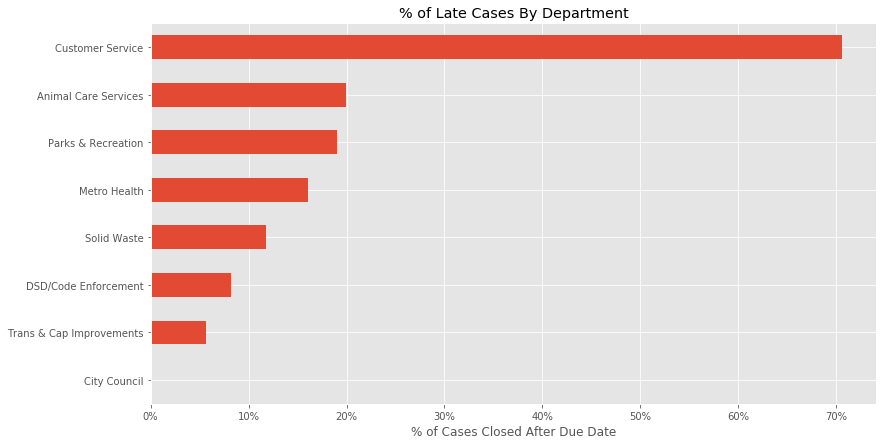

In [5]:
# Does the percentage of cases that are late vary by department?
(
    df.withColumn('case_late', col('case_late').cast('int'))
    .groupby('department')
    .agg(avg('case_late').alias('p_cases_late'))
    .toPandas()
    .set_index('department')
    .p_cases_late
    .sort_values()
    .plot.barh()
)

plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))
plt.gca().set(ylabel='', xlabel='% of Cases Closed After Due Date', title='% of Late Cases By Department')

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Avg # of Days Late'),
 Text(0.5, 1.0, 'How late are the late cases?')]

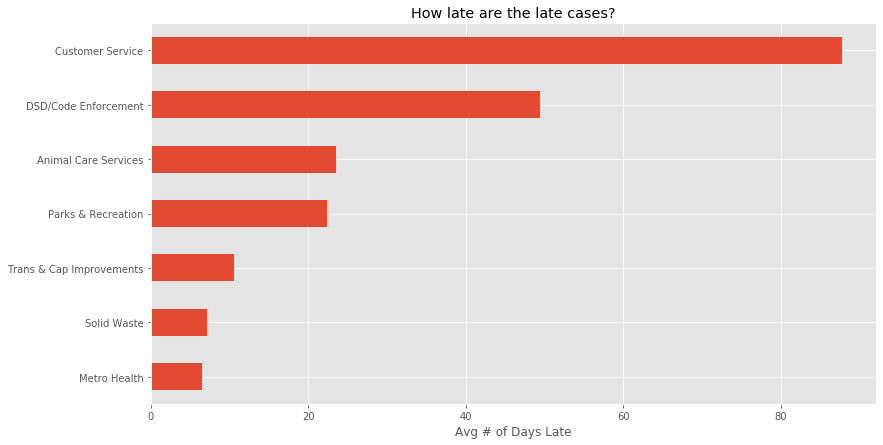

In [6]:
# On average, how late are the late cases by department?
(
    df.filter('case_late')
    .groupby('department')
    .agg(avg('num_days_late')
    .alias('avg_days_late'))
    .toPandas()
    .set_index('department')
    .avg_days_late
    .sort_values()
    .plot.barh()
)

plt.gca().set(ylabel='', xlabel='Avg # of Days Late', title='How late are the late cases?')

[Text(0, 0.5, ''),
 Text(0.5, 0, '# of Days Late'),
 Text(0.5, 1.0, 'Most Late Cases For Parks & Recreation')]

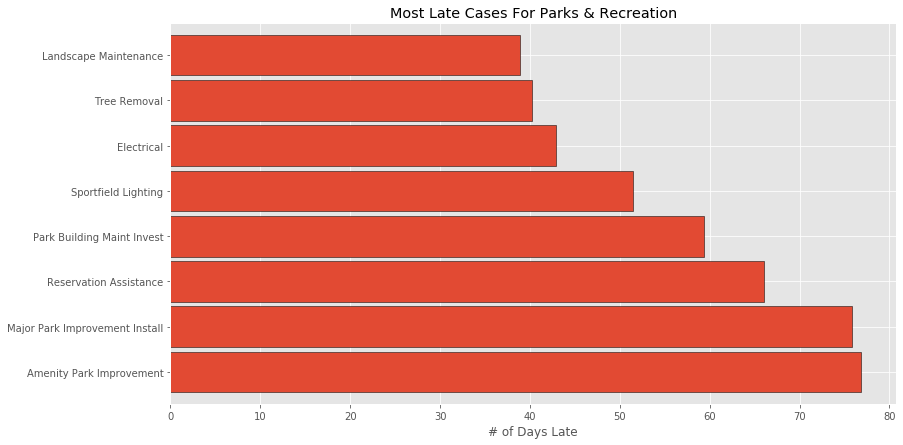

In [7]:
# What is the service type that is the most late? Just for Parks & Rec?
(
    df.filter(df.case_late)
    .filter(df.department == 'Parks & Recreation')
    .groupby('service_request_type')
    .agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(8) # limit in spark, not pandas
    .toPandas()
    .set_index('service_request_type')
    .avg_days_late
    .plot.barh(ec='black', width=.9)
)

plt.gca().set(title='Most Late Cases For Parks & Recreation', xlabel='# of Days Late', ylabel='')

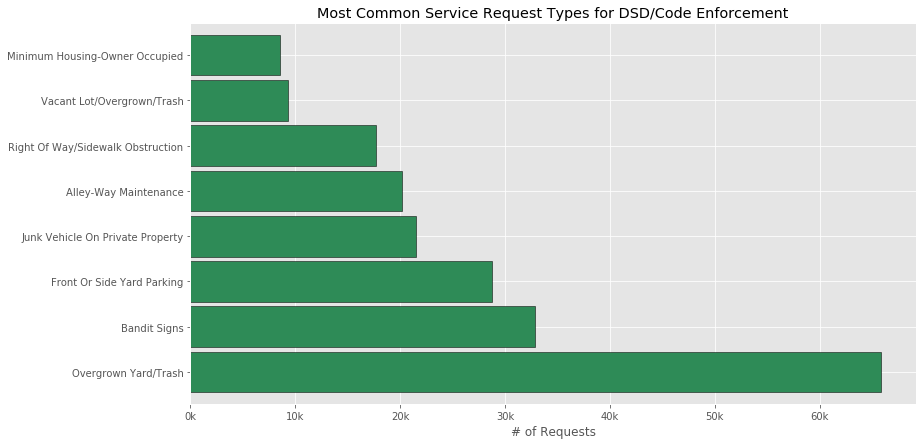

In [8]:
# For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
(
    df.filter(expr('department == "DSD/Code Enforcement"'))
    .groupby('service_request_type')
    .count()
    .sort(desc('count'))
    .limit(8)
    .toPandas()
    .set_index('service_request_type')
    ['count']
    .plot.barh(color='seagreen', width=.9, ec='black')
)

plt.gca().set(ylabel='', xlabel='# of Requests', title='Most Common Service Request Types for DSD/Code Enforcement')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number))

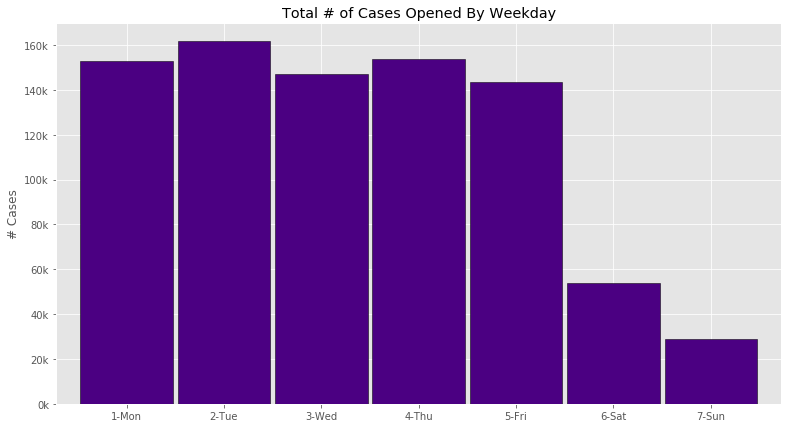

In [9]:
# Does whether or not its a weekend matter for when a case is opened/closed?
(
    df.withColumn('weekday', date_format('case_opened_date', 'u-E'))
    .groupby('weekday')
    .count()
    .na.drop()
    .toPandas()
    .set_index('weekday')
    ['count']
    .sort_index()
    .plot.bar(width=.95, ec='black', color='indigo')
)

plt.xticks(rotation=0)
plt.gca().set(xlabel='', ylabel='# Cases', title='Total # of Cases Opened By Weekday')
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number))

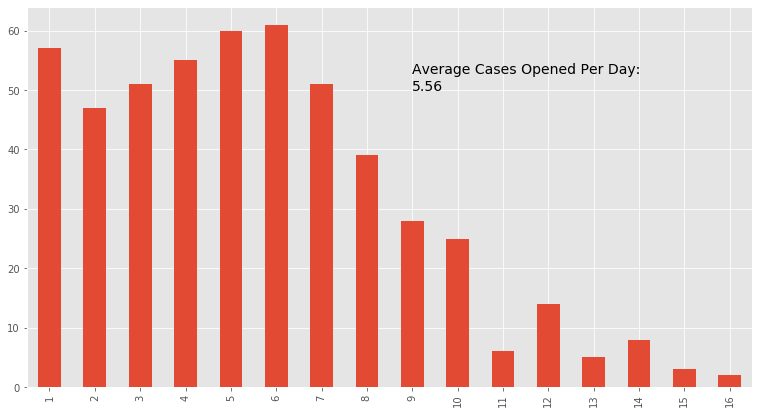

In [10]:
# On average, how many cases are opened a day for the Customer Service department?

def plot_cases(df):
    s = df['count']
    avg = s.mean()
    s.value_counts().sort_index().plot.bar()
    plt.text(8, 50, f'Average Cases Opened Per Day:\n{avg:.2f}', ha='left', size=14)


(
    df.withColumn('case_opened_date', expr('date(case_opened_date)'))
    .filter(df.department == 'Customer Service')
    .groupby('case_opened_date')
    .count()
    .toPandas()
    .pipe(plot_cases)
)

In [12]:
# Does the number of service requests for the solid waste department vary by day of the week?
# Does whether or not its a weekend matter for when a case is opened/closed?
(
    df.withColumn('weekday', date_format('case_opened_date', 'u-E'))
    .filter(expr('department == "Solid Waste"'))
    .groupby('weekday')
    .count()
    .show()
)

+-------+-----+
|weekday|count|
+-------+-----+
|  1-Mon|58085|
|   null|    3|
|  3-Wed|41947|
|  6-Sat|15312|
|  4-Thu|47718|
|  2-Tue|58120|
|  7-Sun| 6882|
|  5-Fri|51203|
+-------+-----+

